# Sklearn package for extracting voronoi data

Link: https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.SphericalVoronoi.html\



github documentation is http://curlba.sh/jhartog/Mihail/blob/e81bc6a1cd9cfcb552e1d6b59eada87e58cd5627/lib/python2.7/site-packages/scipy/spatial/_spherical_voronoi.py

The convex hull of input points is calculated . 

The regions, ridge vertices are estimated for data set provided by Dilip.

In [44]:
from ase.io import read,write
import pymatgen
from pymatgen.analysis.local_env import VoronoiNN
from scipy.spatial import Voronoi, SphericalVoronoi
from pymatgen.io.ase import AseAtomsAdaptor
import os
import pickle
import uuid
import json
from collections import OrderedDict, Iterable, Mapping
from multiprocess import Pool
import numpy as np
import gc
import tqdm
import ase.io
from ase import Atoms
from ase.constraints import FixAtoms
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.local_env import VoronoiNN
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable

def fingerprint_atoms_2(atoms):
    '''
    This function is used to fingerprint an adslabs atoms object, where the "fingerprint" is a
    dictionary of properties that we believe may be adsorption motifs.
    Inputs:
        atoms   Atoms object to fingerprint. The slab atoms must be tagged with 0 and
                adsorbate atoms must be tagged with non-zero integers. This function also
                assumes that the first atom in each adsorbate is the binding atom (e.g.,
                of all atoms with tag==1, the first atom is the binding; the same goes for
                tag==2 and tag==3 etc.).
    '''
#     # Remove the adsorbate(s) while finding the binding position(s)
#     atoms, binding_positions = remove_adsorbate(atoms)
#     # Add Uranium atoms at each of the binding sites so that we can use them for fingerprinting.
#     for tag in binding_positions:
#         atoms += Atoms('U', positions=[binding_positions[tag]])

    # Turn the atoms into a pymatgen structure object so that we can use the VCF to find
    # the coordinated sites.
    struct = AseAtomsAdaptor.get_structure(atoms)

    #Test to see if the central atom is entirely on it's own, if so it is not coordinated, so skip the voronoi bit
    # which would throw a QHULL error
    num_cutoff_neighbors = [site[0] for site in enumerate(struct) if 0.1 < struct[len(atoms)-1].distance(site[1]) < 7.0]
    if len(num_cutoff_neighbors) == 0:
        return {'coordination': '',
                'neighborcoord': '',
                'natoms': len(atoms),
                'nextnearestcoordination': ''}

    vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=10)
    vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=10)
    try:
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    except ValueError:
        vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=40)
        vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=40)
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms = [atom_data['site'] for atom_data in coordinated_atoms_data]
    # Create a list of symbols of the coordinations, remove uranium from the list, and
    # then turn the list into a single, human-readable string.
    coordinated_symbols = map(lambda x: x.species_string, coordinated_atoms)
    coordinated_symbols = [a for a in coordinated_symbols if a not in ['U']]
    coordination = '-'.join(sorted(coordinated_symbols))

    # Make a [list] of human-readable coordination sites [unicode] for all of the slab atoms
    # that are coordinated to the adsorbate, "neighborcoord"
    neighborcoord = []
    for i in coordinated_atoms:
        # [int] that yields the slab+ads system's atomic index for the 1st-tier-coordinated atom
        neighborind = [site[0] for site in enumerate(struct) if i.distance(site[1]) < 0.1][0]
        # [list] of PyMatGen [periodic site class]es for each of the atoms that are coordinated
        # with the adsorbate
        coord_data = vnn_loose.get_nn_info(struct, neighborind)
        coord = [atom_data['site'] for atom_data in coord_data]
        # The elemental symbols for all of the 2nd-tier-coordinated atoms in a [list] of
        # [unicode] objects
        coord_symbols = map(lambda x: x.species_string, coord)
        # Take out atoms that we assume are not part of the slab
        coord_symbols = [a for a in coord_symbols if a not in ['U']]
        # Sort the list of 2nd-tier-coordinated atoms to induce consistency
        coord_symbols.sort()
        # Turn the [list] of [unicode] values into a single [unicode]
        neighborcoord.append(i.species_string+':'+'-'.join(coord_symbols))

    # [list] of PyMatGen [periodic site class]es for each of the atoms that are
    # coordinated with the adsorbate
    coordinated_atoms_nextnearest_data = vnn_loose.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms_nextnearest = [atom_data['site'] for atom_data in coordinated_atoms_nextnearest_data]
    # The elemental symbols for all of the coordinated atoms in a [list] of [unicode] objects
    coordinated_symbols_nextnearest = map(lambda x: x.species_string,
                                          coordinated_atoms_nextnearest)
    # Take out atoms that we assume are not part of the slab
    coordinated_symbols_nextnearest = [a for a in coordinated_symbols_nextnearest
                                       if a not in ['U']]
    # Turn the [list] of [unicode] values into a single [unicode]
    coordination_nextnearest = '-'.join(sorted(coordinated_symbols_nextnearest))

    # Return a dictionary with each of the fingerprints. Any key/value pair can be added here
    # and will propagate up the chain
    return {'coordination': coordination,
            'neighborcoord': neighborcoord,
            'natoms': len(atoms),
            'nextnearestcoordination': coordination_nextnearest}

def nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    C=neighbors['coordination']    
    return C.count(atom_type)

def next_nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    N=neighbors['neighborcoord']
    NN=neighbors['nextnearestcoordination']
    N_count=0
    for i in range(len(N)):
        s=N[i]
        sub_s=s[s.index(':') + len(':'):]
        N_count+=sub_s.count(atom_type)
    return N_count

# Create Gaussian distributions and write to xlsx
def ret_Gaussian(mu,sigma):
    s = np.random.normal(mu, sigma, 2000)
    return s
s=ret_Gaussian(1,0.1)


def featurize_new(atoms):
    a=fingerprint_atoms_2(atoms)
    C=a['coordination']
    N=a['neighborcoord']
    NN=a['nextnearestcoordination']
    neighbor_types=['S','Ni','Co', 'Cr', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    atom_number=np.array([16,28,27,24,29,25,42,23,44,21])
    chi=np.array([2.58,1.91,1.88,1.66,1.90,1.55,2.16,1.63,2.2,1.36])

    std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])
    feature_vec=np.zeros((3,2*len(neighbor_types)))
    for i in range(len(neighbor_types)):
        if nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i]=(np.array([atom_number[i],chi[i],nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i]=(np.array([0,0,0])).T
    for i in range(len(neighbor_types)):
        if next_nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i+len(neighbor_types)]=(np.array([atom_number[i],chi[i],next_nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i+len(neighbor_types)]=(np.array([0,0,0])).T

    return feature_vec


In [45]:
## Fetching DGOH data all sulfide classes

import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable
path='newdata_complete_small'
comp = ['CoS','CuS','MnS','MoS','RuS','ScS','TiS','VS']


####################################################
#loading all file names 
def find_xyz_filenames( path_to_dir, suffix=".xyz" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# size_vec=np.array([10,13,12,..,5])
# for j in range(len(size_vec)):
#     for i in range(size_vec[j]):
#         read(str(i)+'.traj')
    


path='newdata_complete_small'
CoS_filenames = find_xyz_filenames(path+'/CoS')
CuS_filenames = find_xyz_filenames(path+'/CuS')
MnS_filenames = find_xyz_filenames(path+'/MnS')
MoS_filenames = find_xyz_filenames(path+'/MoS')
RuS_filenames = find_xyz_filenames(path+'/RuS')
ScS_filenames = find_xyz_filenames(path+'/ScS')
TiS_filenames = find_xyz_filenames(path+'/TiS')
VS_filenames = find_xyz_filenames(path+'/VS')


#####################################################
#loading the excel file
def find_xlsx_filenames( path_to_dir, suffix=".xlsx" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

xlsx_filenames = find_xlsx_filenames('data')



######################################################
#loading xlsx data
path ='data/'+xlsx_filenames[0]

##reading the data from each sheet
df = pd.read_excel(path,sheet_name=0)
delta_g_CoS = df[df.columns[0]]
ads_CoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=1)
delta_g_CuS = df[df.columns[0]]
ads_CuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=2)
delta_g_MnS = df[df.columns[0]]
ads_MnS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=3)
delta_g_TiS = df[df.columns[0]]
ads_TiS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=4)
delta_g_RuS = df[df.columns[0]]
ads_RuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=5)
delta_g_MoS = df[df.columns[0]]
ads_MoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=6)
delta_g_ScS = df[df.columns[0]]
ads_ScS = df[df.columns[1]]


df = pd.read_excel(path,sheet_name=7)
delta_g_VS = df[df.columns[0]]
ads_VS = df[df.columns[1]]

DGOH=np.hstack((delta_g_CoS,delta_g_CuS,delta_g_MnS,delta_g_TiS,delta_g_RuS,delta_g_MoS,delta_g_ScS,delta_g_VS))




In [46]:
## Building feature vector from all sulfides


def fetchdata(filenames,stringname,size):
    neighbor_types=['S','Ni','Co', 'Cr', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    featureVectorStack=np.zeros((3,2*len(neighbor_types),size))
    path='newdata_complete_small'
    r = 0
    for i in range(0,len(filenames)):
        atoms=read(path+'/'+stringname+'/'+str(i)+'.xyz')
        featureVectorStack[:,:,i]=featurize_new(atoms)
    return featureVectorStack
        
       
FV1=fetchdata(CoS_filenames,'CoS',len(delta_g_CoS))  
FV2=fetchdata(CuS_filenames,'CuS',len(delta_g_CuS))  
FV3=fetchdata(MnS_filenames,'MnS',len(delta_g_MnS))  
FV4=fetchdata(TiS_filenames,'TiS',len(delta_g_TiS))
FV5=fetchdata(RuS_filenames,'RuS',len(delta_g_RuS))  
FV6=fetchdata(MoS_filenames,'MoS',len(delta_g_MoS))  
FV7=fetchdata(ScS_filenames,'ScS',len(delta_g_ScS))  
FV8=fetchdata(VS_filenames,'VS',len(delta_g_VS))  



In [47]:
from sklearn.svm import SVR
import numpy as np
FV=np.dstack((FV1,FV2,FV3,FV4,FV5,FV6,FV7,FV8))
r,c,d=FV.shape
FV_reshape = FV.reshape((r*c,d))
print(FV_reshape.shape)

DGOH.shape=((len(DGOH),1))
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
DGOH=DGOH.astype(np.float)
FV_reshape=FV_reshape.astype(np.float)

print ( np.shape(FV_reshape)[1])
print (len(DGOH))

for i in range(0, len(DGOH)):
    DGOH[i] = int(DGOH[i])
    for k in range(0, np.shape(FV_reshape)[0]):
        FV_reshape[k,i] = int(FV_reshape[k,i])


clf.fit(np.array(FV_reshape.T),np.array(DGOH))
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)



(60, 49)
49
49


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: must be real number, not str

In [48]:
print(type(DGOH))
print(type(FV_reshape))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [60]:
import sklearn.model_selection
from tpot import TPOTRegressor
from sklearn.metrics.scorer import make_scorer


############################
#parameter descriptions:
#generations = how many iterations to go through in optimizer
#population_size = number of individuals to retain in algrotihm every generation (will work better with more, but take longer)
#random_state = random seed going into optimizer. Should get the same result if we use the same data and seed
#changing seed may affect result
#verbosity = how much TPOT prints out while it's running, integer value 0-3. 0=prints nothing, 3=prints everything
###############################

# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return np.std(y_pred- y_true)

# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=False)

# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
#                       scoring=my_custom_scorer)



optimizer = TPOTRegressor(generations=10, population_size=10, random_state=99, verbosity=2,periodic_checkpoint_folder="tpot_results.txt" ,
                      scoring=my_custom_scorer)


#fit to training data
print (FV_reshape.shape)
print (DGOH.shape)
optimizer.fit(np.asmatrix(FV_reshape.T), DGOH)

(60, 49)
(49, 1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Generation 1 - Current best internal CV score: -0.46143803392157245
Generation 2 - Current best internal CV score: -0.46143803392157245
Generation 3 - Current best internal CV score: -0.42344048424291925
Generation 4 - Current best internal CV score: -0.42344048424291925
Generation 5 - Current best internal CV score: -0.42344048424291925
Generation 6 - Current best internal CV score: -0.42344048424291925
Generation 7 - Current best internal CV score: -0.41482685649950835
Generation 8 - Current best internal CV score: -0.41482685649950835
Generation 9 - Current best internal CV score: -0.41482685649950835
Generation 10 - Current best internal CV score: -0.41482685649950835

Best pipeline: LinearSVR(RobustScaler(input_matrix), C=0.001, dual=True, epsilon=0.1, loss=squared_epsilon_insensitive, tol=0.001)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=10,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder='tpot_results.txt', population_size=10,
       random_state=99,
       scoring=make_scorer(my_custom_accuracy, greater_is_better=False),
       subsample=1.0, use_dask=False, verbosity=2, warm_start=False)

In [54]:
result = optimizer.predict(np.asmatrix(FV_reshape.T))

print (np.std(result-DGOH))

0.9081293794031999


In [55]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(FV_reshape.T))
dg = np.array(DGOH)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

print (x.shape)
print (y.shape)

#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2, n_out, batch_size = 60, 60,60, 1, 60



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),
                     nn.Linear(n_h2, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%100 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


torch.Size([49, 60])
torch.Size([49, 1])
epoch:  0  loss:  1.4941203594207764
epoch:  100  loss:  0.08763361722230911
epoch:  200  loss:  0.06631101667881012
epoch:  300  loss:  0.06509847193956375
epoch:  400  loss:  0.0646013468503952
epoch:  500  loss:  0.06427284330129623
epoch:  600  loss:  0.0640697106719017
epoch:  700  loss:  0.06395561248064041
epoch:  800  loss:  0.06389812380075455
epoch:  900  loss:  0.06387156248092651
epoch:  1000  loss:  0.06385941803455353
epoch:  1100  loss:  0.06385316699743271
epoch:  1200  loss:  0.06384919583797455
epoch:  1300  loss:  0.0638461709022522
epoch:  1400  loss:  0.06384366750717163
epoch:  1500  loss:  0.06384152919054031
epoch:  1600  loss:  0.06383973360061646
epoch:  1700  loss:  0.06383822113275528
epoch:  1800  loss:  0.06453550606966019
epoch:  1900  loss:  0.06383714079856873
epoch:  2000  loss:  0.06383573263883591
epoch:  2100  loss:  0.06396523863077164
epoch:  2200  loss:  0.0638372078537941
epoch:  2300  loss:  0.0638348683

0.25265247


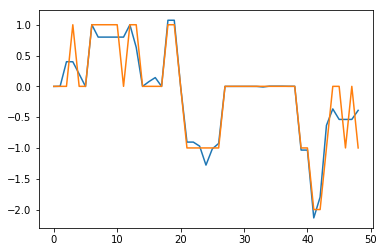

In [56]:


y1_pred = y_pred.detach().numpy()
y1  = y.detach().numpy()

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

In [ ]:
print (optimizer.score)

In [ ]:
(optimizer.score(np.asmatrix(FV_reshape.T), DGOH))